In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)

In [4]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_v2_base.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]

hashes, hparams = TSTInfo.find({
    "experiment_name": experiment_name,
    "n_3b": n_3b,
    "ratio_4b": ratio_4b,
}, return_hparams=True)

seeds = np.unique([hp["seed"] for hp in hparams])
signal_ratios = np.unique([hp["signal_ratio"] for hp in hparams])
n_3bs = np.unique([hp["n_3b"] for hp in hparams])

tst_results = []
result_size = 0

0it [00:00, ?it/s]

1500it [01:08, 22.04it/s] 


In [6]:
def get_histogram_info(events, values, bins):
    assert len(events) == len(values)

    if isinstance(bins, int):
        # calculate quantiles
        q = np.linspace(0, 1, bins + 1)
        bins = np.quantile(values, q)
    
    hist_3b, _ = np.histogram(values[events.is_3b], bins=bins, weights=events.weights[events.is_3b])
    hist_bg4b, _ = np.histogram(values[events.is_bg4b], bins=bins, weights=events.weights[events.is_bg4b])
    hist_signal, _ = np.histogram(values[events.is_signal], bins=bins, weights=events.weights[events.is_signal])
    hist_4b, _ = np.histogram(values[events.is_4b], bins=bins, weights=events.weights[events.is_4b])

    std_est = np.sqrt((hist_3b + hist_4b) / 2)
    is_sampled = std_est > 0
    sigma = (hist_4b - hist_3b)[is_sampled]  / std_est[is_sampled]
    sigma_avg = np.sqrt(np.mean(sigma**2))
    sigma_bg4b = (hist_bg4b - hist_3b)[is_sampled] / std_est[is_sampled]
    sigma_avg_bg4b = np.sqrt(np.mean(sigma_bg4b**2))
    df = np.sum(is_sampled)

    return {
        "hist_3b": hist_3b,
        "hist_bg4b": hist_bg4b,
        "hist_signal": hist_signal,
        "hist_4b": hist_4b,
        "std_est": std_est,
        "sigma": sigma,
        "sigma_avg": sigma_avg,
        "sigma_bg4b": sigma_bg4b,
        "sigma_avg_bg4b": sigma_avg_bg4b,
        "df": df,
    }

0it [00:00, ?it/s]

1500it [00:03, 456.04it/s] 
  0%|          | 0/5 [00:00<?, ?it/s]

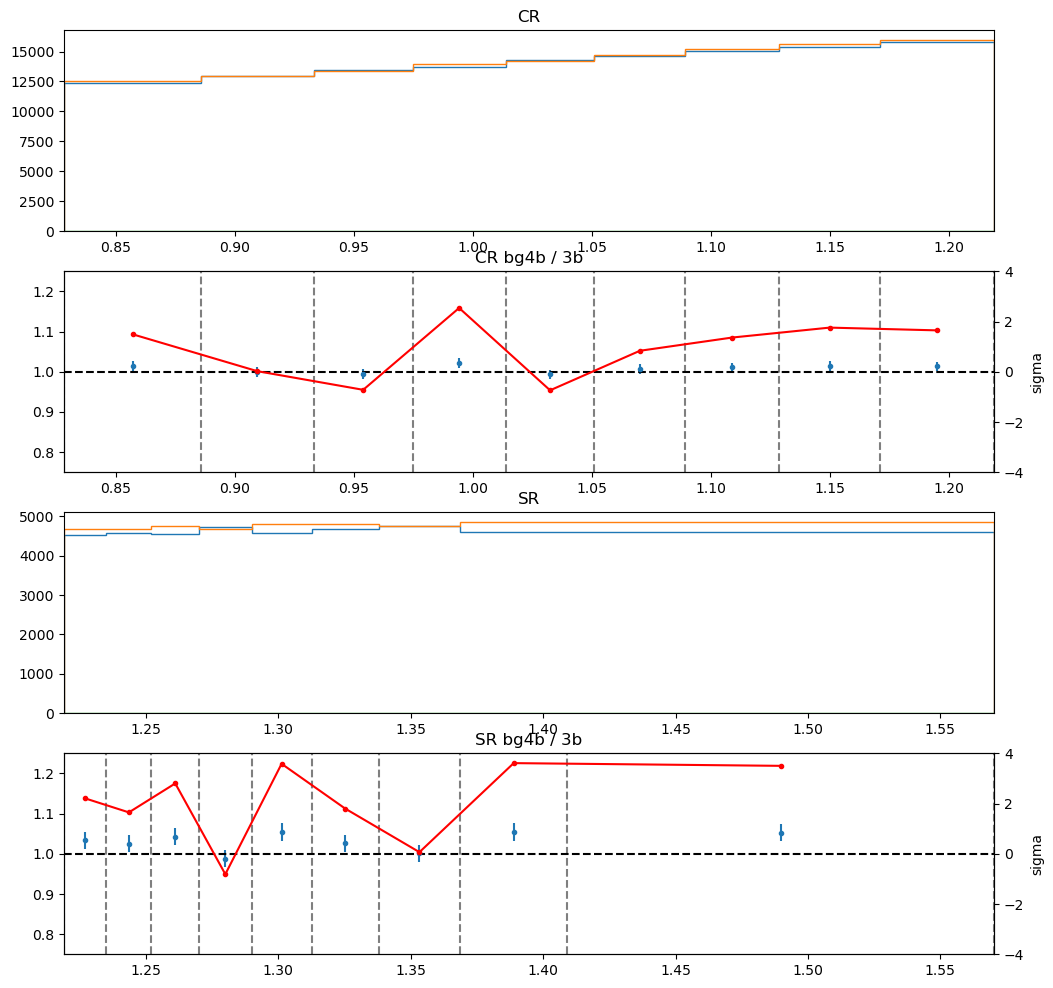

nbin:  1 sigma_avg_SR:  6.207503 sigma_avg_CR:  2.7832599 last_sigma_SR:  6.207503 last_sigma_CR:  2.7832599
nbin:  2 sigma_avg_SR:  4.3893795 sigma_avg_CR:  2.0700104 last_sigma_SR:  4.3991117 last_sigma_CR:  2.6524088
nbin:  3 sigma_avg_SR:  3.6436656 sigma_avg_CR:  1.838116 last_sigma_SR:  4.1966033 last_sigma_CR:  2.7642465
nbin:  4 sigma_avg_SR:  3.5677762 sigma_avg_CR:  1.4720432 last_sigma_SR:  5.555469 last_sigma_CR:  1.76832
nbin:  5 sigma_avg_SR:  2.9041855 sigma_avg_CR:  1.4552734 last_sigma_SR:  3.7298226 last_sigma_CR:  2.560546
nbin:  6 sigma_avg_SR:  2.7403805 sigma_avg_CR:  1.3531291 last_sigma_SR:  4.5679064 last_sigma_CR:  2.4109278
nbin:  7 sigma_avg_SR:  2.8284943 sigma_avg_CR:  1.3082786 last_sigma_SR:  4.895966 last_sigma_CR:  2.075545
nbin:  8 sigma_avg_SR:  2.6780157 sigma_avg_CR:  1.1885273 last_sigma_SR:  4.162533 last_sigma_CR:  1.8361189
nbin:  9 sigma_avg_SR:  2.5579932 sigma_avg_CR:  1.4237002 last_sigma_SR:  3.5497897 last_sigma_CR:  1.6536384


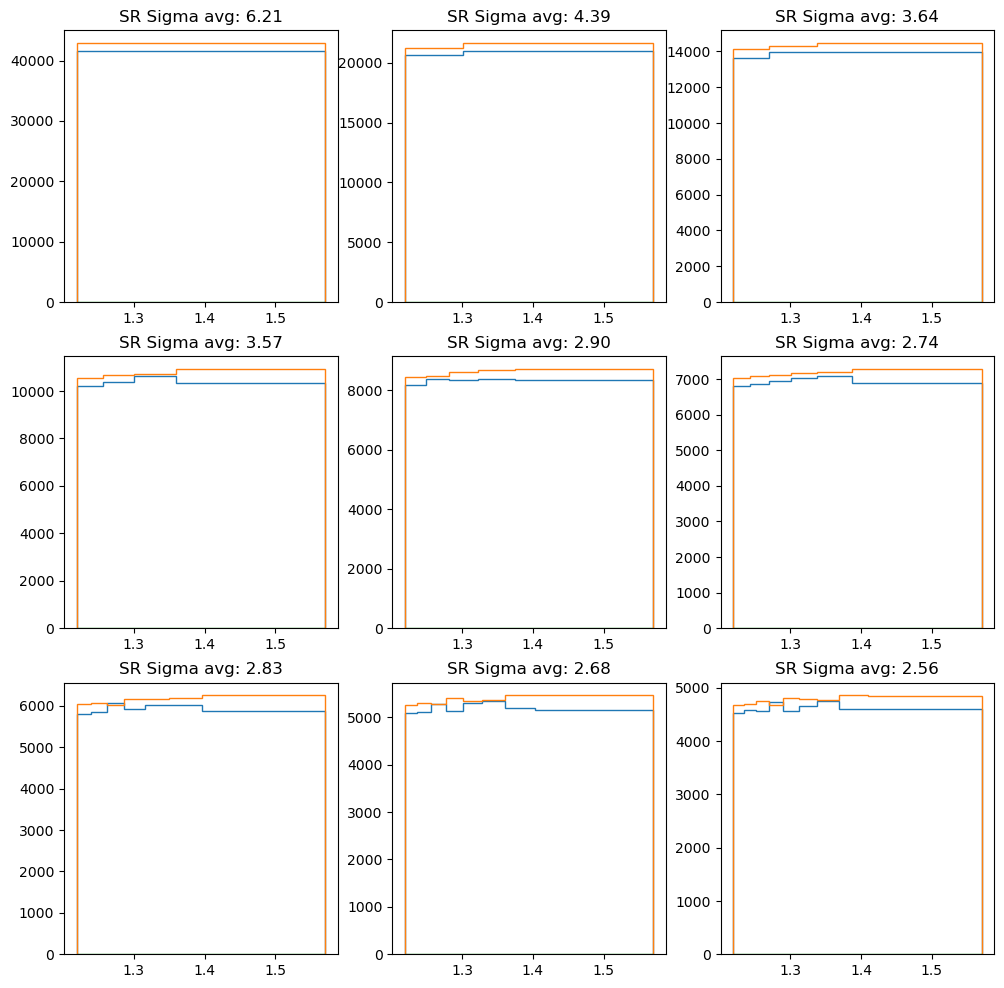

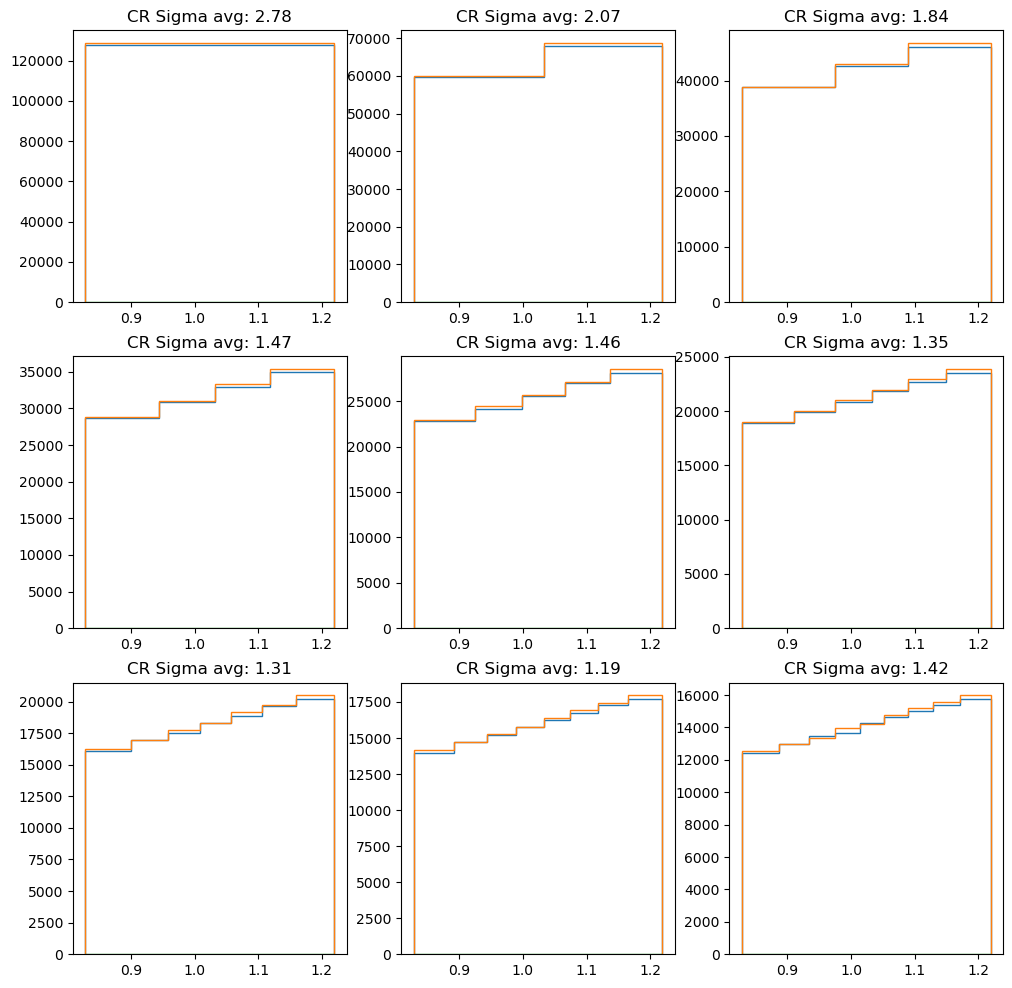

 20%|██        | 1/5 [00:08<00:34,  8.52s/it]

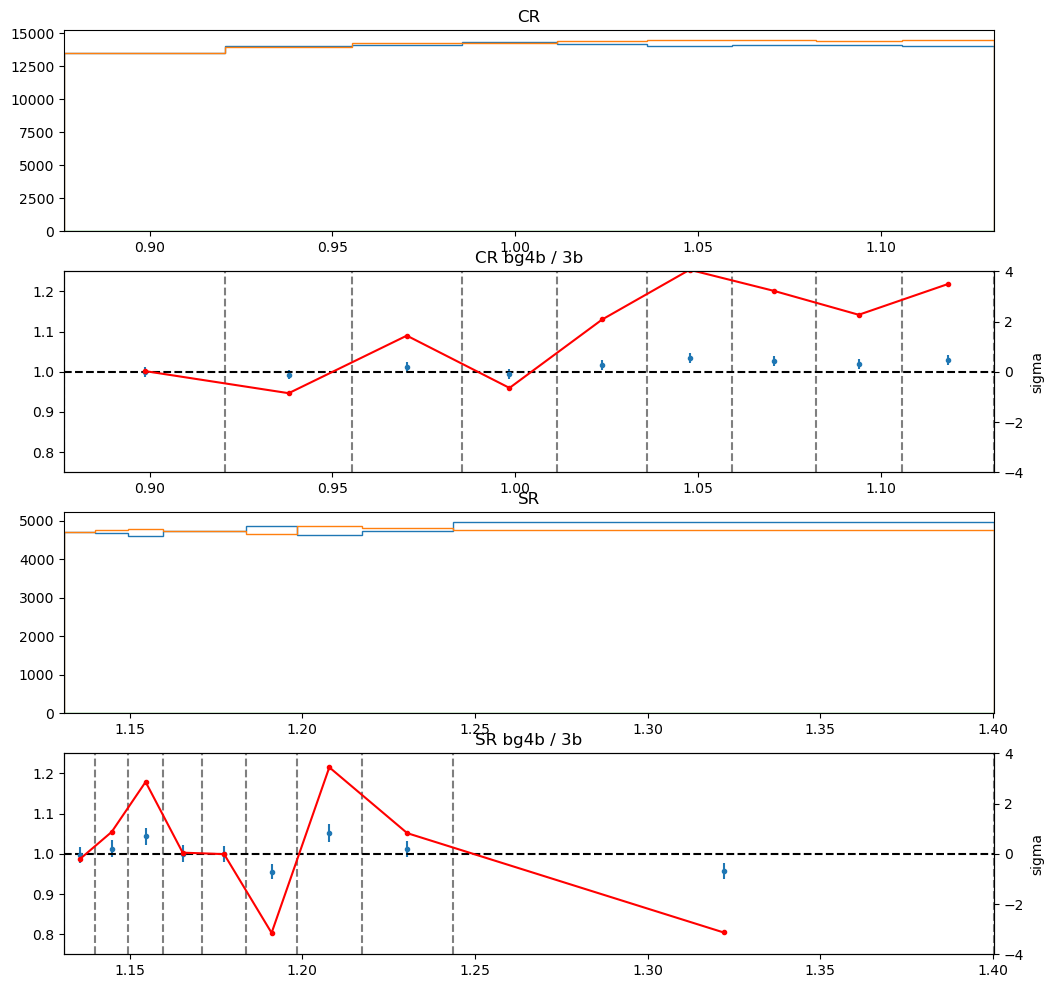

nbin:  1 sigma_avg_SR:  0.54750496 sigma_avg_CR:  5.0899024 last_sigma_SR:  0.54750496 last_sigma_CR:  5.0899024
nbin:  2 sigma_avg_SR:  1.8626368 sigma_avg_CR:  4.784319 last_sigma_SR:  -1.427371 last_sigma_CR:  6.7530737
nbin:  3 sigma_avg_SR:  1.6171436 sigma_avg_CR:  3.5407932 last_sigma_SR:  0.68078506 last_sigma_CR:  5.2196565
nbin:  4 sigma_avg_SR:  1.4771428 sigma_avg_CR:  3.5182142 last_sigma_SR:  -0.32853165 last_sigma_CR:  3.8305542
nbin:  5 sigma_avg_SR:  1.6044716 sigma_avg_CR:  3.0338576 last_sigma_SR:  -2.314354 last_sigma_CR:  4.5386114
nbin:  6 sigma_avg_SR:  2.3665948 sigma_avg_CR:  2.9026177 last_sigma_SR:  -2.1494641 last_sigma_CR:  4.6466956
nbin:  7 sigma_avg_SR:  1.8096281 sigma_avg_CR:  2.681324 last_sigma_SR:  -2.2881727 last_sigma_CR:  4.013494
nbin:  8 sigma_avg_SR:  2.0003006 sigma_avg_CR:  2.69452 last_sigma_SR:  -2.9629695 last_sigma_CR:  4.111127
nbin:  9 sigma_avg_SR:  2.1426892 sigma_avg_CR:  2.414675 last_sigma_SR:  -3.0944767 last_sigma_CR:  3.5186164

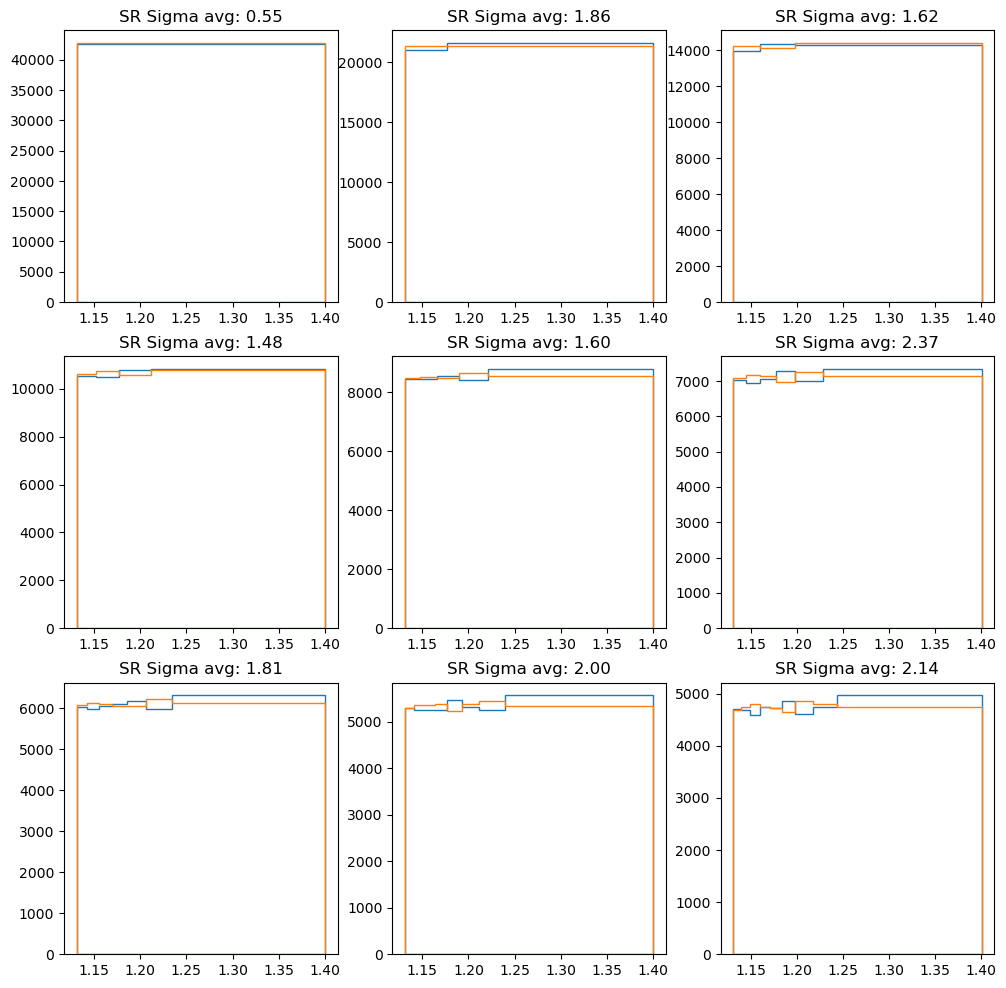

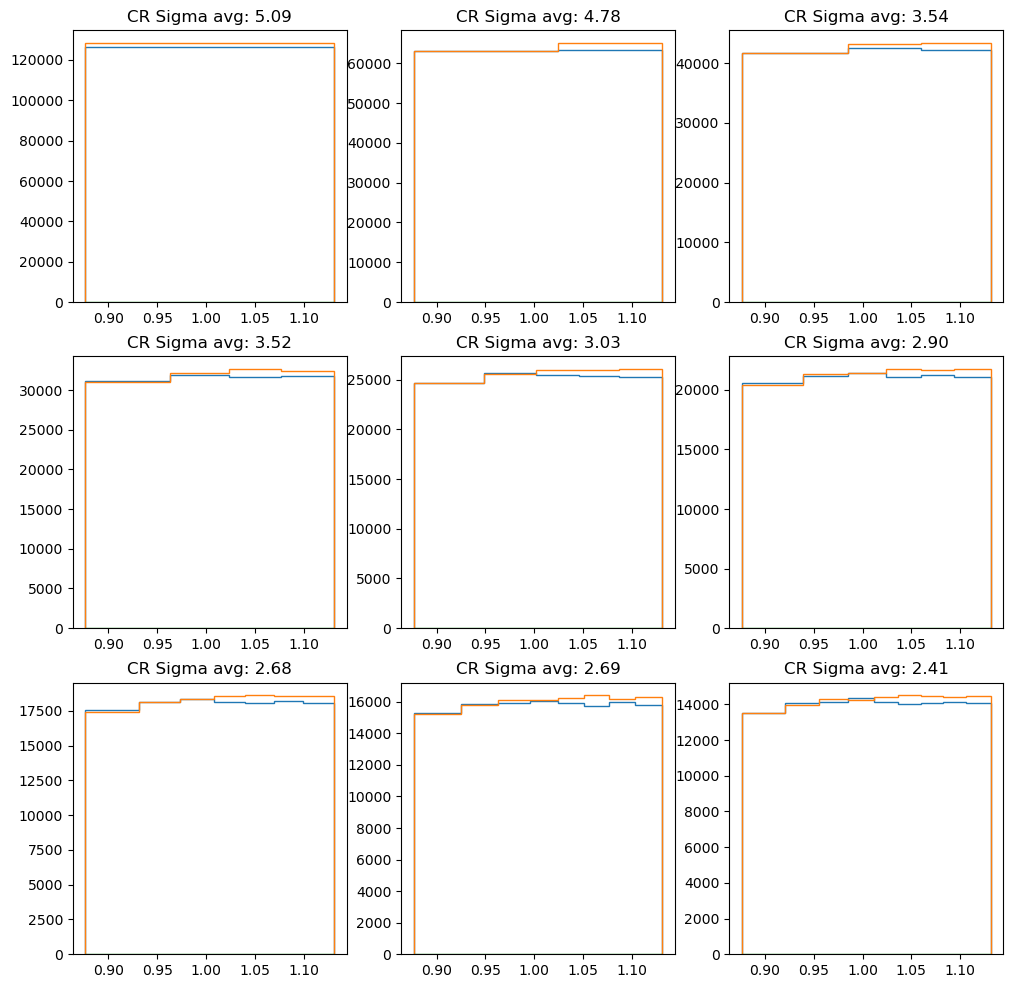

 40%|████      | 2/5 [00:17<00:26,  8.67s/it]

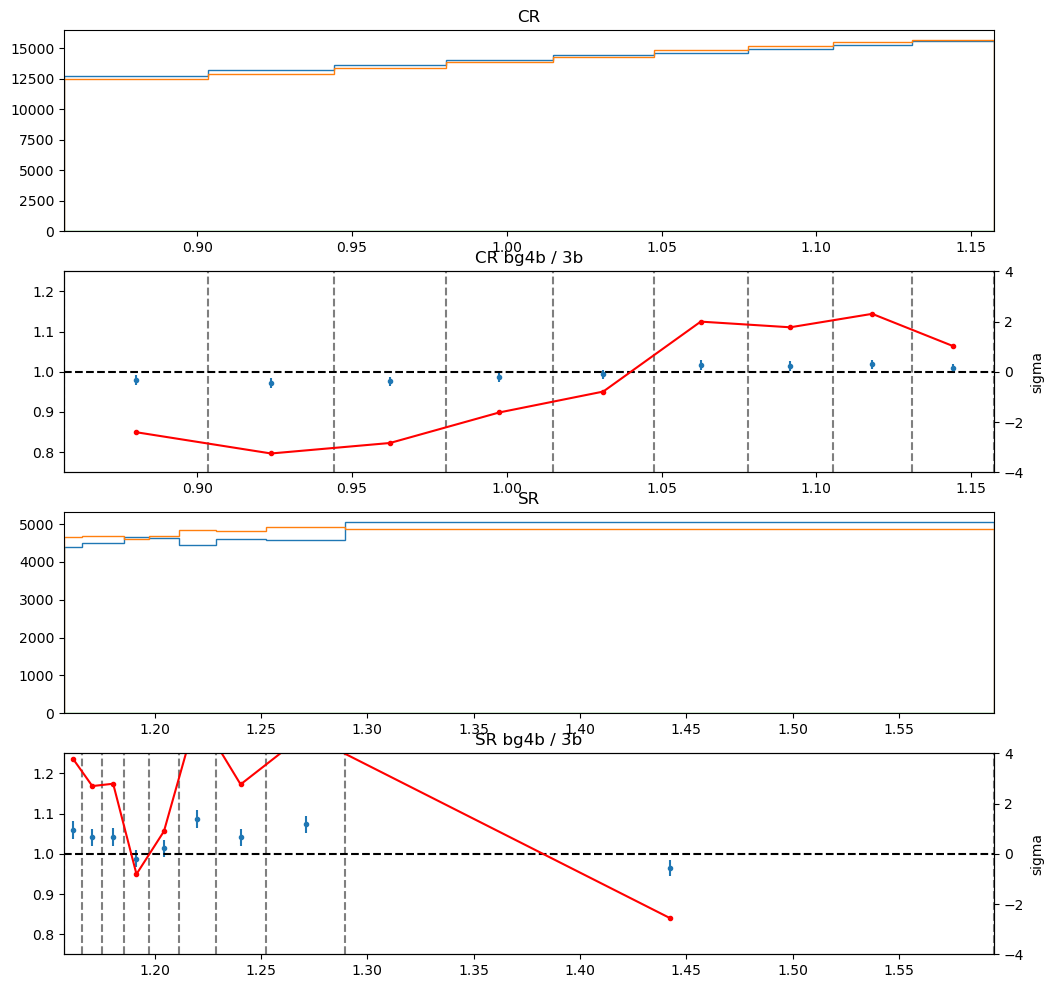

nbin:  1 sigma_avg_SR:  6.7207375 sigma_avg_CR:  1.0426006 last_sigma_SR:  6.7207375 last_sigma_CR:  -1.0426006
nbin:  2 sigma_avg_SR:  4.8423104 sigma_avg_CR:  4.625841 last_sigma_SR:  5.7140493 last_sigma_CR:  3.6661196
nbin:  3 sigma_avg_SR:  4.040408 sigma_avg_CR:  3.2957382 last_sigma_SR:  2.9036255 last_sigma_CR:  2.9539318
nbin:  4 sigma_avg_SR:  4.0960646 sigma_avg_CR:  3.4383993 last_sigma_SR:  1.8934242 last_sigma_CR:  3.1437826
nbin:  5 sigma_avg_SR:  3.5717068 sigma_avg_CR:  3.0837247 last_sigma_SR:  0.90913665 last_sigma_CR:  1.245083
nbin:  6 sigma_avg_SR:  3.6732407 sigma_avg_CR:  2.858123 last_sigma_SR:  0.14451456 last_sigma_CR:  0.49450406
nbin:  7 sigma_avg_SR:  3.7510571 sigma_avg_CR:  2.6541746 last_sigma_SR:  -1.6391197 last_sigma_CR:  1.3305912
nbin:  8 sigma_avg_SR:  3.5306 sigma_avg_CR:  2.5524397 last_sigma_SR:  -2.1625104 last_sigma_CR:  1.8534657
nbin:  9 sigma_avg_SR:  3.36887 sigma_avg_CR:  2.1334286 last_sigma_SR:  -2.5322442 last_sigma_CR:  1.0285244


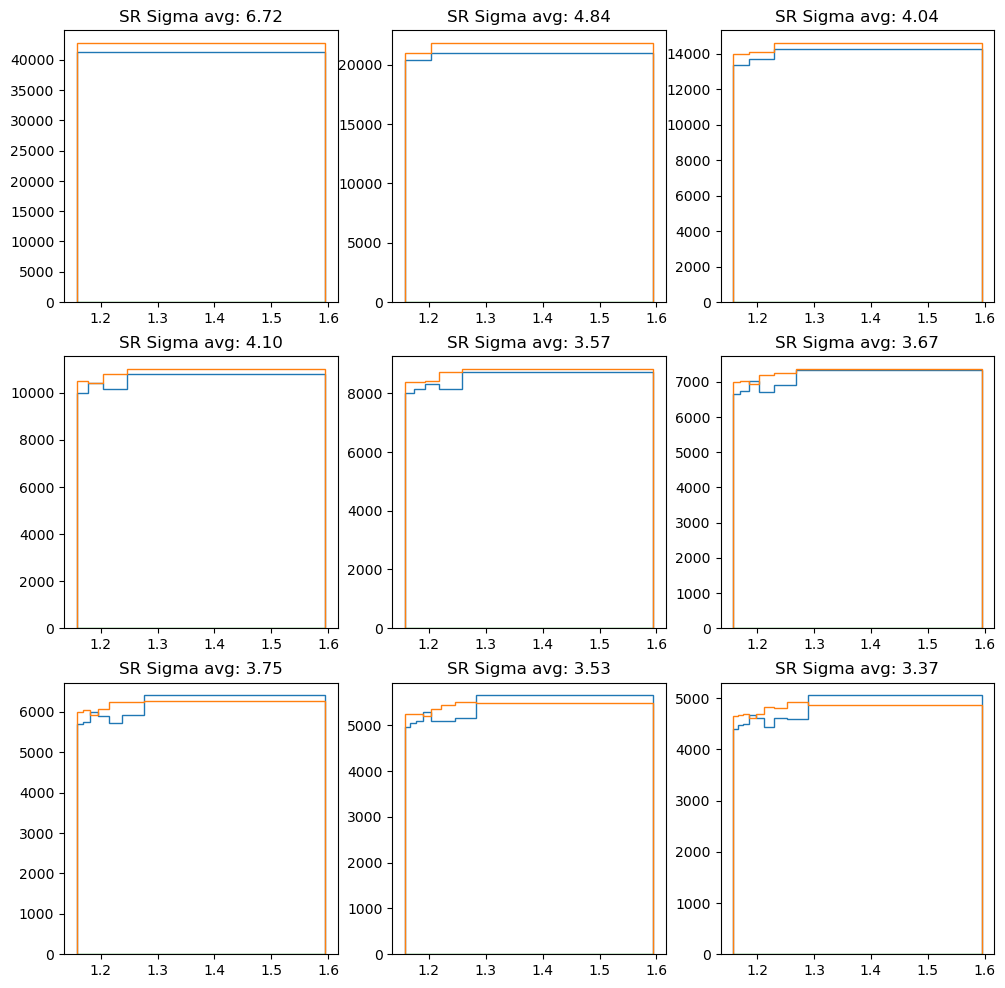

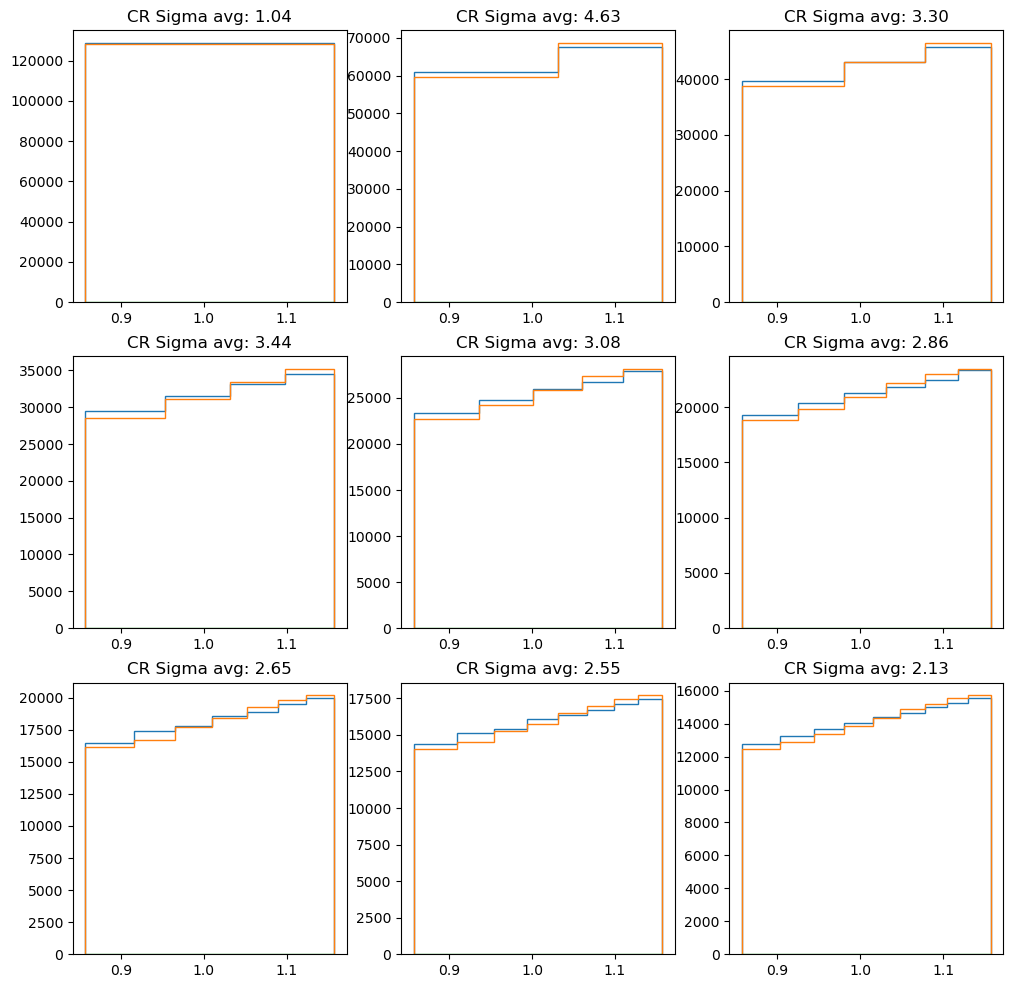

 60%|██████    | 3/5 [00:25<00:17,  8.58s/it]

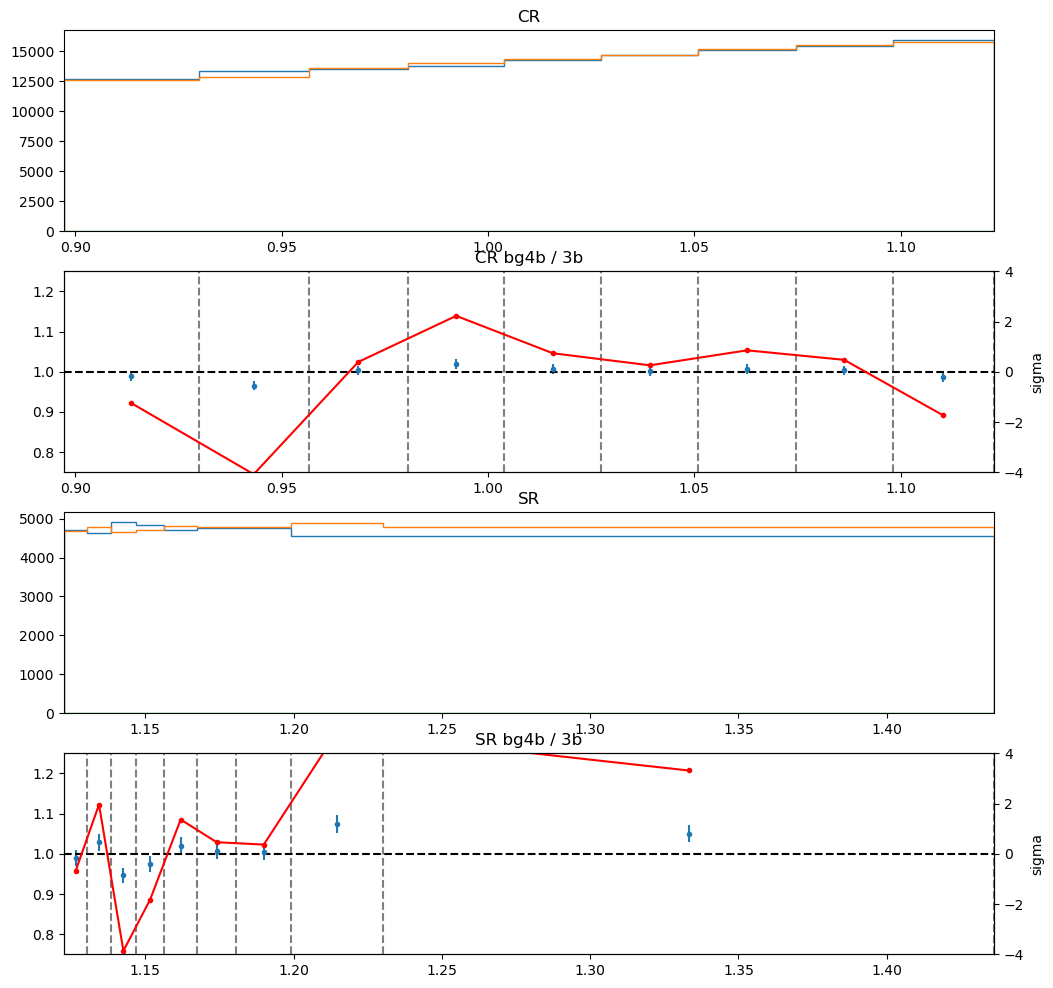

nbin:  1 sigma_avg_SR:  2.0461895 sigma_avg_CR:  0.6366763 last_sigma_SR:  2.0461895 last_sigma_CR:  -0.6366763
nbin:  2 sigma_avg_SR:  3.597829 sigma_avg_CR:  0.6186916 last_sigma_SR:  4.7418504 last_sigma_CR:  -0.053060066
nbin:  3 sigma_avg_SR:  3.0101612 sigma_avg_CR:  1.949837 last_sigma_SR:  5.0040774 last_sigma_CR:  -0.24952824
nbin:  4 sigma_avg_SR:  3.1748853 sigma_avg_CR:  2.0947156 last_sigma_SR:  5.6069217 last_sigma_CR:  -1.6986629
nbin:  5 sigma_avg_SR:  3.1305807 sigma_avg_CR:  1.9825593 last_sigma_SR:  5.6063714 last_sigma_CR:  -0.8411188
nbin:  6 sigma_avg_SR:  2.553723 sigma_avg_CR:  1.6497829 last_sigma_SR:  3.3778248 last_sigma_CR:  -0.5496458
nbin:  7 sigma_avg_SR:  2.594244 sigma_avg_CR:  1.9405518 last_sigma_SR:  3.490983 last_sigma_CR:  0.12770429
nbin:  8 sigma_avg_SR:  2.4802842 sigma_avg_CR:  1.7496319 last_sigma_SR:  2.862659 last_sigma_CR:  -0.2584224
nbin:  9 sigma_avg_SR:  2.5869803 sigma_avg_CR:  1.7527554 last_sigma_SR:  3.3600366 last_sigma_CR:  -1.733

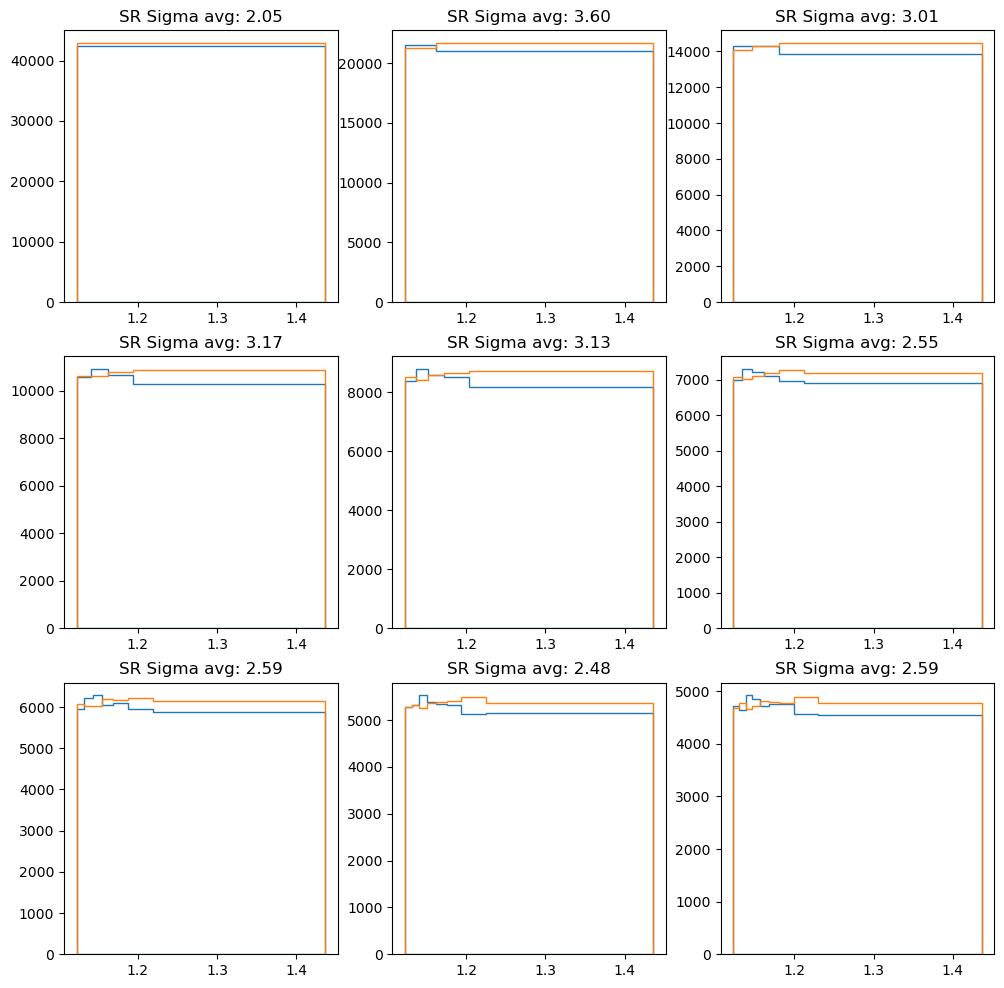

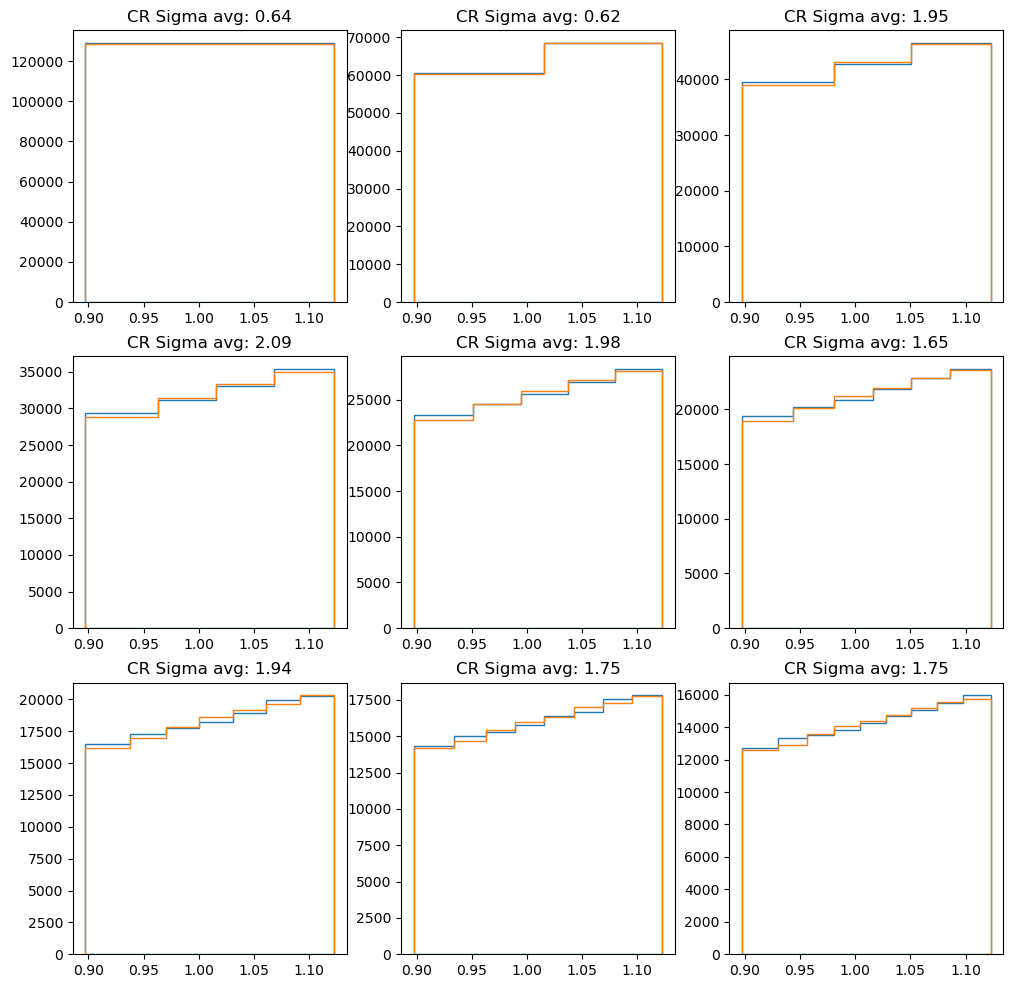

 80%|████████  | 4/5 [00:34<00:08,  8.67s/it]

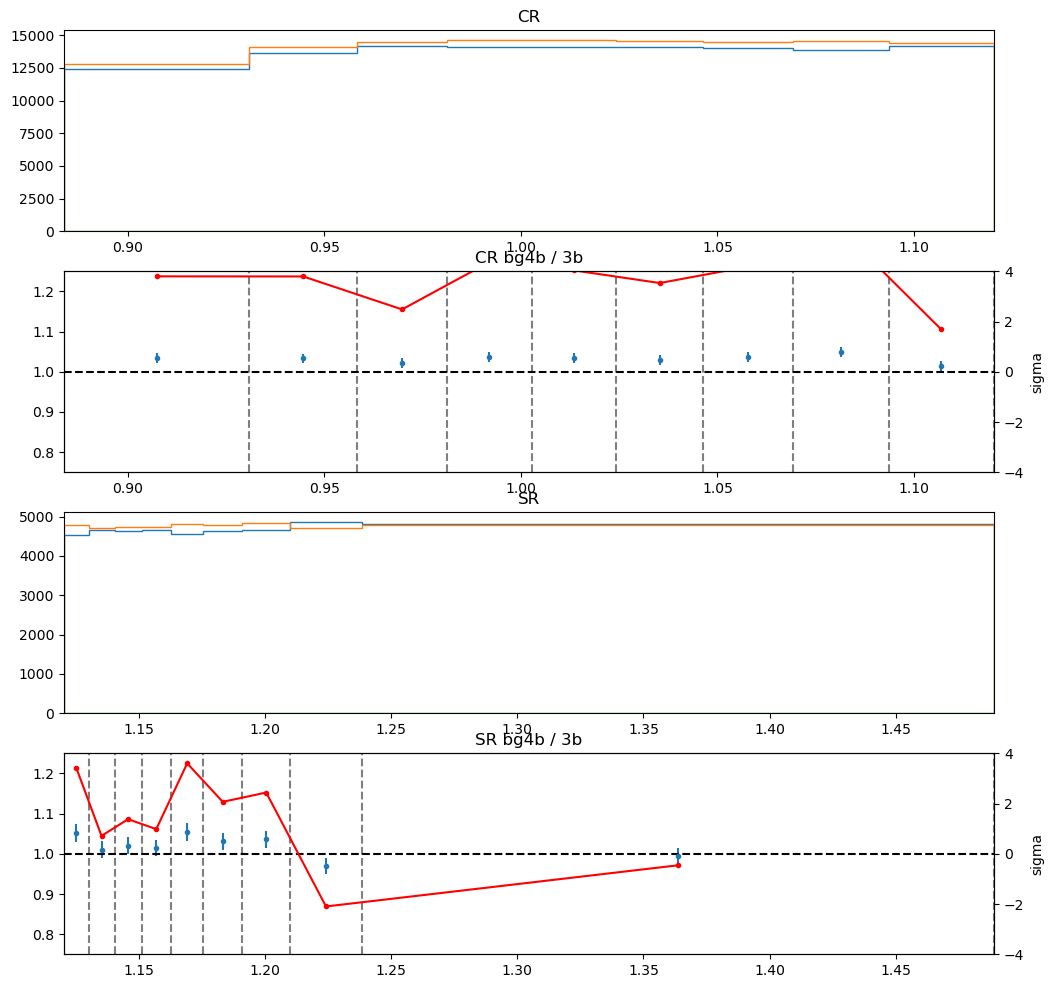

nbin:  1 sigma_avg_SR:  4.0549455 sigma_avg_CR:  11.27412 last_sigma_SR:  4.0549455 last_sigma_CR:  11.27412
nbin:  2 sigma_avg_SR:  3.0162594 sigma_avg_CR:  7.9752393 last_sigma_SR:  1.9456216 last_sigma_CR:  7.8076105
nbin:  3 sigma_avg_SR:  2.9103923 sigma_avg_CR:  6.521415 last_sigma_SR:  -0.05082849 last_sigma_CR:  6.71794
nbin:  4 sigma_avg_SR:  2.8613682 sigma_avg_CR:  5.6514807 last_sigma_SR:  -1.3020194 last_sigma_CR:  6.0058784
nbin:  5 sigma_avg_SR:  2.8153145 sigma_avg_CR:  5.1015105 last_sigma_SR:  -2.2052152 last_sigma_CR:  4.441003
nbin:  6 sigma_avg_SR:  2.5233188 sigma_avg_CR:  4.650678 last_sigma_SR:  -2.0541282 last_sigma_CR:  4.6929574
nbin:  7 sigma_avg_SR:  2.4374988 sigma_avg_CR:  4.2747765 last_sigma_SR:  -1.889379 last_sigma_CR:  4.3043833
nbin:  8 sigma_avg_SR:  2.171991 sigma_avg_CR:  4.1591005 last_sigma_SR:  -1.4326643 last_sigma_CR:  2.5441756
nbin:  9 sigma_avg_SR:  2.204106 sigma_avg_CR:  3.9124227 last_sigma_SR:  -0.4565355 last_sigma_CR:  1.6890043


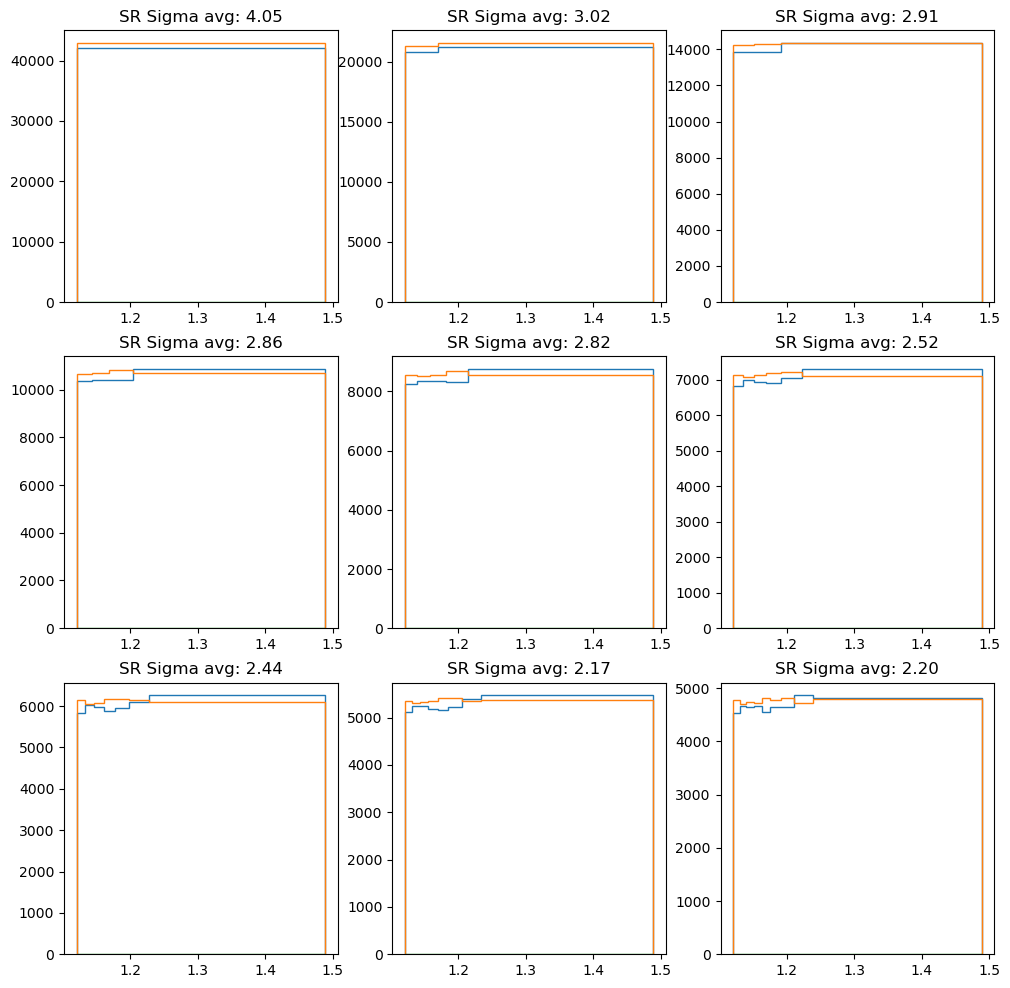

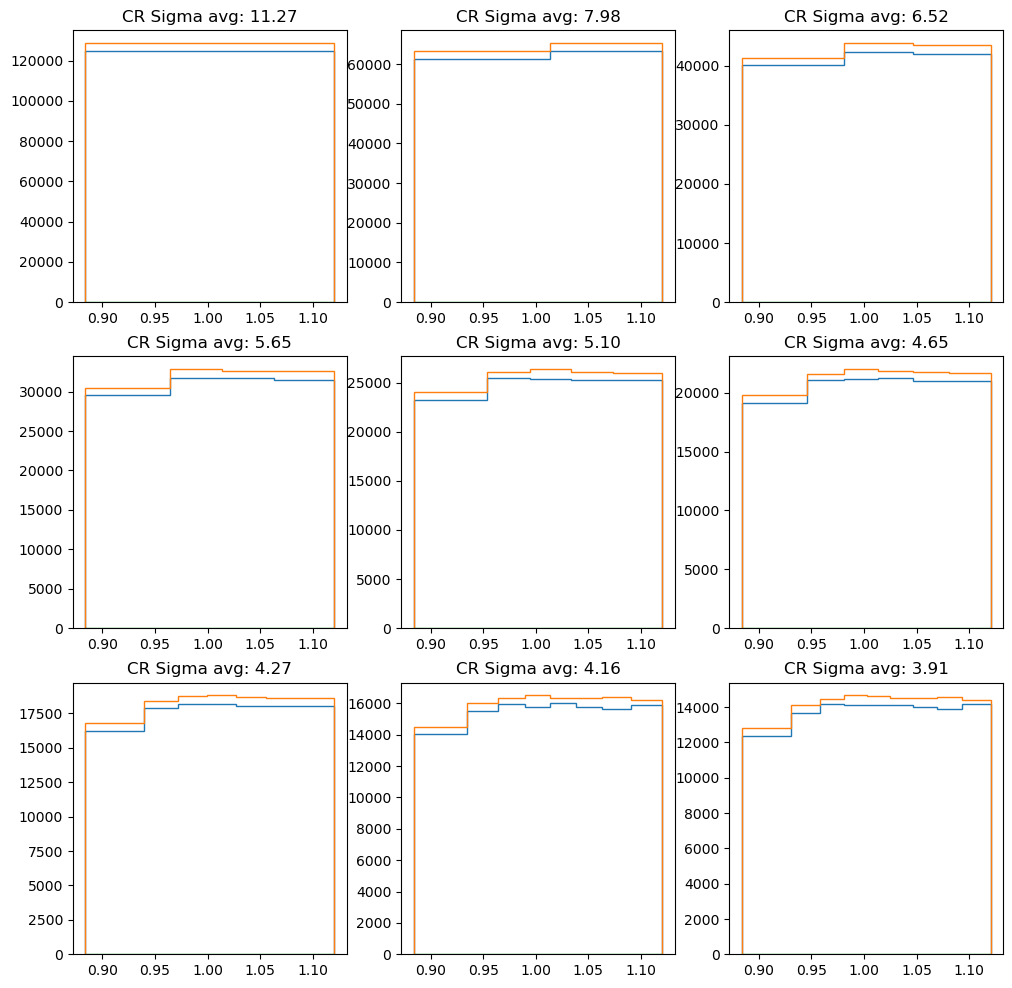

100%|██████████| 5/5 [00:43<00:00,  8.65s/it]


In [29]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams["lines.markersize"] = 3

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_v2"],
    "n_3b": 100_0000,
    "seed": lambda x: x < 5,
    "signal_ratio": 0.0,
}

hashes = TSTInfo.find(hparam_filter)
tst_results_summary = []

for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):

    if tstinfo_hash in [r["hash"] for r in tst_results]:
        continue

    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]
    
    initialize_with_fvt = True if experiment_name == "counting_test_v2" else False

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()

    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
    events_tst.reweight(
        np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))
    
    events_SR = events_tst[in_SR]
    events_CR = events_tst[in_CR]
    SR_stats_SR = SR_stats[in_SR]
    SR_stats_CR = SR_stats[in_CR]

    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 1, figure=fig)

    # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), 10)
    q = np.linspace(0, 1, 10)
    bins = np.quantile(SR_stats_CR, q)

    ax = fig.add_subplot(gs[0])
    hist_events_by_labels(events_CR, SR_stats_CR, bins=bins, ax=ax)
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_title("CR")

    hist_3b, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins, weights=events_CR.weights[events_CR.is_3b])
    hist_bg4b, _ = np.histogram(SR_stats_CR[events_CR.is_bg4b], bins=bins, weights=events_CR.weights[events_CR.is_bg4b])
    ax = fig.add_subplot(gs[1])
    midpoints = (bins[1:] + bins[:-1]) / 2
    err = (hist_bg4b / hist_3b) * np.sqrt(1 / hist_bg4b + 1 / hist_3b)
    ax.errorbar(midpoints, hist_bg4b / hist_3b, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
    ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_ylim((0.75, 1.25))
    ax.set_title("CR bg4b / 3b")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

    ax2 = ax.twinx()
    sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b)
    ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
    ax2.set_ylim((-4, 4))
    ax2.set_ylabel("sigma")

    
    # bins = np.linspace(np.min(SR_stats_SR), np.max(SR_stats_SR), 10)
    q = np.linspace(0, 1, 10)
    bins = np.quantile(SR_stats_SR, q)

    ax = fig.add_subplot(gs[2])
    hist_events_by_labels(events_SR, SR_stats_SR, bins=bins, ax=ax)
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_title("SR")

    hist_3b, _ = np.histogram(SR_stats_SR[events_SR.is_3b], bins=bins, weights=events_SR.weights[events_SR.is_3b])
    hist_bg4b, _ = np.histogram(SR_stats_SR[events_SR.is_bg4b], bins=bins, weights=events_SR.weights[events_SR.is_bg4b])
    ax = fig.add_subplot(gs[3])
    midpoints = (bins[1:] + bins[:-1]) / 2
    err = (hist_bg4b / hist_3b) * np.sqrt(1 / hist_bg4b + 1 / hist_3b)
    ax.errorbar(midpoints, hist_bg4b / hist_3b, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
    ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_ylim((0.75, 1.25))
    ax.set_title("SR bg4b / 3b")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

    ax2 = ax.twinx()
    sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b)
    ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
    ax2.set_ylim((-4, 4))
    ax2.set_ylabel("sigma")


    plt.show()
    
    
    # tst_results.append({
    #     "signal_ratio": signal_ratio,
    #     "seed": seed,
    #     "events_SR": events_SR,
    #     "events_CR": events_CR,
    #     "SR_stats_SR": SR_stats_SR,
    #     "SR_stats_CR": SR_stats_CR,
    #     "SR_cut": SR_cut,
    #     "CR_cut": CR_cut,
    #     "CR_model_output_CR": probs_4b_est[in_CR],
    #     "CR_model_output_SR": probs_4b_est[in_SR],
    #     "initialize_with_fvt": initialize_with_fvt,
    #     "hash": tstinfo_hash,
    # })
    # result_size += (
    #     events_SR.get_memory_usage() + events_CR.get_memory_usage() +
    #     SR_stats_SR.nbytes + SR_stats_CR.nbytes
    # ) / 1024**2

    # pbar.set_postfix({"Result size (MB)": result_size})
    
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(3, 3, figure=fig)

    fig2 = plt.figure(figsize=(12, 12))
    gs2 = GridSpec(3, 3, figure=fig2)

    nbins_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    for ax_cnt, nbin in enumerate(nbins_list):
        ax = fig.add_subplot(gs[ax_cnt])
        ax2 = fig2.add_subplot(gs2[ax_cnt])

        q = np.linspace(0, 1, nbin + 1)
        bins_SR = np.quantile(SR_stats_SR, q)
        bins_CR = np.quantile(SR_stats_CR, q)

        # hist_events_by_labels(events_tst, SR_stats, bins_SR=bins_SR, ax=ax)
        hist_events_by_labels(events_SR, SR_stats_SR, bins=bins_SR, ax=ax)
        hist_events_by_labels(events_CR, SR_stats_CR, bins=bins_CR, ax=ax2)
        
        hist_info_SR = get_histogram_info(events_SR, SR_stats_SR, nbin)
        hist_info_CR = get_histogram_info(events_CR, SR_stats_CR, nbin)

        ax.set_title(f"SR Sigma avg: {hist_info_SR['sigma_avg']:.2f}")
        ax2.set_title(f"CR Sigma avg: {hist_info_CR['sigma_avg']:.2f}")

        print("nbin: ", nbin,
              "sigma_avg_SR: ", hist_info_SR["sigma_avg"], 
              "sigma_avg_CR: ", hist_info_CR["sigma_avg"], 
              "last_sigma_SR: ", hist_info_SR["sigma"][-1],
                "last_sigma_CR: ", hist_info_CR["sigma"][-1],
        )
        
        tst_results_summary.append({
            "signal_ratio": signal_ratio,
            "seed": seed,
            "nbin": nbin,
            "sigma_avg_SR": hist_info_SR["sigma_avg"],
            "sigma_avg_bg4b_SR": hist_info_SR["sigma_avg_bg4b"],
            "sigma_avg_CR": hist_info_CR["sigma_avg"],
            "sigma_avg_bg4b_CR": hist_info_CR["sigma_avg_bg4b"],
            "initialize_with_fvt": initialize_with_fvt,
            "df_SR": hist_info_SR["df"],
            "df_CR": hist_info_CR["df"],
            "reweight": "CR"
        })
        
    plt.show()
# tst_results_summary_df = pd.DataFrame(tst_results_summary)    

In [9]:
pd.DataFrame(tst_results_summary).groupby(["signal_ratio", "nbin", "reweight"]).mean().reset_index()

,signal_ratio,nbin,reweight,seed,sigma_avg_SR,sigma_avg_bg4b_SR,sigma_avg_CR,sigma_avg_bg4b_CR,initialize_with_fvt,df_SR,df_CR
0,0.00,1,CR,2.0,3.915376,3.915376,4.165312,4.165312,1.0,1.0,1.0
1,0.00,2,CR,2.0,3.541683,3.541683,4.014820,4.014820,1.0,2.0,2.0
2,0.00,3,CR,2.0,3.044354,3.044354,3.429180,3.429180,1.0,3.0,3.0
3,0.00,4,CR,2.0,3.035447,3.035447,3.234971,3.234971,1.0,4.0,4.0
4,0.00,5,CR,2.0,2.805252,2.805252,2.931385,2.931385,1.0,5.0,5.0
5,0.00,6,CR,2.0,2.771451,2.771451,2.682866,2.682866,1.0,6.0,6.0
6,0.00,7,CR,2.0,2.684185,2.684185,2.571821,2.571821,1.0,7.0,7.0
7,0.00,8,CR,2.0,2.572238,2.572238,2.468844,2.468844,1.0,8.0,8.0
8,0.00,9,CR,2.0,2.572128,2.572128,2.327396,2.327396,1.0,9.0,9.0
9,0.01,1,CR,2.0,2.015821,4.805986,2.506467,4.661662,1.0,1.0,1.0


In [13]:
from scipy import stats

deg_free = 1
np.sqrt(stats.chi2.ppf(0.95, deg_free) / deg_free)

1.9599639845400538

In [38]:
sig_level = 0.05
tst_results_summary_df["rejected_SR"] = tst_results_summary_df["sigma_avg_SR"]**2 > stats.chi2.ppf(1-sig_level, tst_results_summary_df["df_SR"]) / tst_results_summary_df["df_SR"]
tst_results_summary_df["rejected_bg4b_SR"] = tst_results_summary_df["sigma_avg_bg4b_SR"]**2 > stats.chi2.ppf(1-sig_level, tst_results_summary_df["df_SR"]) / tst_results_summary_df["df_SR"]
tst_results_summary_df["rejected_CR"] = tst_results_summary_df["sigma_avg_CR"]**2 > stats.chi2.ppf(1-sig_level, tst_results_summary_df["df_CR"]) / tst_results_summary_df["df_CR"]
tst_results_summary_df["rejected_bg4b_CR"] = tst_results_summary_df["sigma_avg_bg4b_CR"]**2 > stats.chi2.ppf(1-sig_level, tst_results_summary_df["df_CR"]) / tst_results_summary_df["df_CR"]

In [40]:
tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).get_group((0.0, 5, "base"))

,signal_ratio,seed,nbin,sigma_avg_SR,sigma_avg_bg4b_SR,sigma_avg_CR,sigma_avg_bg4b_CR,initialize_with_fvt,df_SR,df_CR,reweight,rejected_SR,rejected_bg4b_SR,rejected_CR,rejected_bg4b_CR
7,0.0,1,5,1.496819,1.496819,1.121609,1.121609,True,4,4,base,False,False,False,False
55,0.0,2,5,1.987140,1.987140,0.877386,0.877386,True,4,4,base,True,True,False,False
103,0.0,3,5,1.672958,1.672958,3.285331,3.285331,True,4,4,base,True,True,True,True
151,0.0,4,5,3.102129,3.102129,2.366776,2.366776,True,4,4,base,True,True,True,True
199,0.0,0,5,2.736025,2.736025,1.680138,1.680138,True,4,4,base,True,True,True,True


In [28]:
tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).mean()

seed  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio nbin reweight                                          
0.00         2    CR         2.0      3.915376           3.915376   
                  base       2.0      1.535162           1.535162   
             3    CR         2.0      3.477000           3.477000   
                  base       2.0      2.137756           2.137756   
             4    CR         2.0      3.080222           3.080222   
                  base       2.0      1.981003           1.981003   
             5    CR         2.0      3.088061           3.088061   
                  base       2.0      2.278172           2.278172   
             6    CR         2.0      2.804148           2.804148   
                  base       2.0      2.080733           2.080733   
             7    CR         2.0      2.757660           2.757660   
                  base       2.0      2.127703           2.127703   
             8    CR         2.0      2.792600           2.792600   
                  base       2.0      2.260291           2.260291   
             9    CR         2.0      2.806285           2.806285   
                  base       2.0      2.363794           2.363794   
0.01         2    CR         2.0      2.015821           4.805986   
                  base       2.0      5.372674           9.110829   
             3    CR         2.0      2.786009           3.772558   
                  base       2.0      4.738810           6.726686   
             4    CR         2.0      2.279692           2.978612   
                  base       2.0      3.763020           5.415041   
             5    CR         2.0      2.135105           2.812459   
                  base       2.0      3.556674           4.908706   
             6    CR         2.0      2.010704           2.796571   
                  base       2.0      3.191386           4.579698   
             7    CR         2.0      2.053807           2.391634   
                  base       2.0      3.017256           4.060151   
             8    CR         2.0      1.943295           2.376175   
                  base       2.0      2.862678           3.856650   
             9    CR         2.0      2.011372           2.466259   
                  base       2.0      2.846584           3.803508   
0.02         2    CR         2.0     10.451992           5.329355   
                  base       2.0      4.673048          16.939453   
             3    CR         2.0     14.445851           4.442788   
                  base       2.0      6.009095          13.646991   
             4    CR         2.0     15.244513           4.274668   
                  base       2.0      5.579186          13.036743   
             5    CR         2.0     14.822182           3.763546   
                  base       2.0      5.673438          12.203085   
             6    CR         2.0     13.929606           3.593695   
                  base       2.0      5.210025          11.514941   
             7    CR         2.0     12.848125           3.461118   
                  base       2.0      4.737427          11.084475   
             8    CR         2.0     12.181340           3.357135   
                  base       2.0      4.686121          10.574780   
             9    CR         2.0     11.536260           3.213416   
                  base       2.0      4.523958          10.086523   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio nbin reweight                                    
0.00         2    CR            4.165312           4.165312   
                  base          2.480238           2.480238   
             3    CR            3.982292           3.982292   
                  base          2.226119           2.226119   
             4    CR            3.603301           3.603301   
                  base          1.901981           1.901981   
             5    CR            3.193247           3.193247   
          

In [45]:
df2 = pd.read_csv("counting_test_v2.tsv", sep="\t")
df2["rejected_SR"] = df2["sigma_avg_SR"]**2 > stats.chi2.ppf(1-sig_level, df2["nbin"]) / df2["nbin"]
df2["rejected_bg4b_SR"] = df2["sigma_avg_bg4b_SR"]**2 > stats.chi2.ppf(1-sig_level, df2["nbin"]) / df2["nbin"]
df2["rejected_CR"] = df2["sigma_avg_CR"]**2 > stats.chi2.ppf(1-sig_level, df2["nbin"]) / df2["nbin"]
df2["rejected_bg4b_CR"] = df2["sigma_avg_bg4b_CR"]**2 > stats.chi2.ppf(1-sig_level, df2["nbin"]) / df2["nbin"]

In [46]:
df2.groupby(["signal_ratio", "nbin", "initialize_with_fvt"]).mean()

seed  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio nbin initialize_with_fvt                                          
0.00         10   False                49.5      4.467074           4.467074   
                  True                 49.5      2.524912           2.524912   
             20   False                49.5      3.390271           3.390271   
                  True                 49.5      2.190580           2.190580   
             30   False                49.5      2.951894           2.951894   
                  True                 49.5      2.046155           2.046155   
             50   False                49.5      2.545473           2.545473   
                  True                 49.5      1.920204           1.920204   
             100  False                49.5      2.173712           2.173712   
                  True                 49.5      1.805822           1.805822   
             200  False                49.5      1.953006           1.953006   
                  True                 49.5      1.748951           1.748951   
0.01         10   False                49.5      5.253260           4.124736   
                  True                 49.5      2.772202           2.416718   
             20   False                49.5      3.877266           3.127371   
                  True                 49.5      2.293043           2.082811   
             30   False                49.5      3.340001           2.751847   
                  True                 49.5      2.145166           1.989858   
             50   False                49.5      2.802465           2.367704   
                  True                 49.5      1.953500           1.842083   
             100  False                49.5      2.349795           2.069904   
                  True                 49.5      1.848529           1.778631   
             200  False                49.5      2.054569           1.877047   
                  True                 49.5      1.771326           1.724917   
0.02         10   False                49.5     15.710117           3.699300   
                  True                 49.5     11.631321           3.381457   
             20   False                49.5     11.144857           2.751437   
                  True                 49.5      8.299827           2.655111   
             30   False                49.5      9.161604           2.371007   
                  True                 49.5      6.872048           2.322296   
             50   False                49.5      7.203453           2.007605   
                  True                 49.5      5.475643           2.000667   
             100  False                49.5      5.273934           1.669442   
                  True                 49.5      4.117279           1.701195   
             200  False                49.5      3.950555           1.455746   
                  True                 49.5      3.206374           1.519194   

                                       sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio nbin initialize_with_fvt                                    
0.00         10   False                    4.595683           4.595683   
                  True                     2.159140           2.159140   
             20   False                    3.405870           3.405870   
                  True                     1.906788           1.906788   
             30   False                    2.902679           2.902679   
                  True                     1.785553           1.785553   
             50   False                    2.461721           2.461721   
                  True                     1.716421           1.716421   
             100  False                    2.051494           2.051494   
                  True                     1.628994           1.628994   
             200  False                    1.834015           1.834015   
                  True              

In [ ]:
# tst_results_summary = []

# for tst_result in tst_results:
#     events_SR = tst_result["events_SR"]
#     events_CR = tst_result["events_CR"]
#     SR_stats_SR = tst_result["SR_stats_SR"]
#     SR_stats_CR = tst_result["SR_stats_CR"]
#     SR_cut = tst_result["SR_cut"]
#     CR_cut = tst_result["CR_cut"]
#     signal_ratio = tst_result["signal_ratio"]
#     seed = tst_result["seed"]
#     CR_model_output_CR = tst_result["CR_model_output_CR"]
#     CR_model_output_SR = tst_result["CR_model_output_SR"]
#     initialize_with_fvt = tst_result["initialize_with_fvt"]

#     nbins = [10, 20, 30, 50, 100, 200]
#     for nbin in nbins:
#         # hist_info_SR = get_histogram_info(events_SR, SR_stats_SR, nbin)
#         # hist_info_CR = get_histogram_info(events_CR, SR_stats_CR, nbin)
#         hist_info_SR = get_histogram_info(events_SR, CR_model_output_SR, nbin)
#         hist_info_CR = get_histogram_info(events_CR, CR_model_output_CR, nbin)

#         tst_results_summary.append({
#             "signal_ratio": signal_ratio,
#             "seed": seed,
#             "nbin": nbin,
#             "sigma_avg_SR": hist_info_SR["sigma_avg"],
#             "sigma_avg_bg4b_SR": hist_info_SR["sigma_avg_bg4b"],
#             "sigma_avg_CR": hist_info_CR["sigma_avg"],
#             "sigma_avg_bg4b_CR": hist_info_CR["sigma_avg_bg4b"],
#             "initialize_with_fvt": initialize_with_fvt,
#         })

# tst_results_summary_df = pd.DataFrame(tst_results_summary)

/tmp/ipykernel_4176273/359779080.py:13: RuntimeWarning: invalid value encountered in divide
  sigma = (hist_4b - hist_3b)  / std_est
/tmp/ipykernel_4176273/359779080.py:15: RuntimeWarning: invalid value encountered in divide
  sigma_bg4b = (hist_bg4b - hist_3b)  / std_est


In [42]:
from scipy import stats

sig_level = 0.05
z = stats.norm.ppf(1 - sig_level / 2)
tst_results_summary_df["rejected_SR"] = tst_results_summary_df["sigma_avg_SR"] > z
tst_results_summary_df["rejected_bg4b_SR"] = tst_results_summary_df["sigma_avg_bg4b_SR"] > z
tst_results_summary_df["rejected_CR"] = tst_results_summary_df["sigma_avg_CR"] > z
tst_results_summary_df["rejected_bg4b_CR"] = tst_results_summary_df["sigma_avg_bg4b_CR"] > z

# tst_results_summary_df.groupby(["signal_ratio", "nbin"]).mean()

In [43]:
tst_results_summary_df.groupby([
    "nbin", 
    "signal_ratio", 
    "initialize_with_fvt"]).mean()

seed  sigma_avg_SR  sigma_avg_bg4b_SR  \
nbin signal_ratio initialize_with_fvt                                          
10   0.00         False                 0.0      5.168311           5.168311   
     0.01         False                 0.0      7.654525           6.034191   
20   0.00         False                 0.0      3.794281           3.794281   
     0.01         False                 0.0      5.338385           4.223228   
30   0.00         False                 0.0      3.239454           3.239454   
     0.01         False                 0.0      4.450324           3.563998   
50   0.00         False                 0.0      2.680188           2.680188   
     0.01         False                 0.0      3.599793           2.957475   
100  0.00         False                 0.0      2.114945           2.114945   
     0.01         False                 0.0      2.789040           2.362969   
200  0.00         False                 0.0      1.857682           1.857682   
     0.01         False                 0.0      2.298802           2.031875   

                                       sigma_avg_CR  sigma_avg_bg4b_CR  \
nbin signal_ratio initialize_with_fvt                                    
10   0.00         False                    4.468959           4.468959   
     0.01         False                    5.259844           4.903814   
20   0.00         False                    3.299375           3.299375   
     0.01         False                    3.819751           3.585240   
30   0.00         False                    2.843111           2.843111   
     0.01         False                    3.238995           3.060959   
50   0.00         False                    2.471611           2.471611   
     0.01         False                    2.645609           2.510746   
100  0.00         False                    2.162473           2.162473   
     0.01         False                    2.065068           1.982297   
200  0.00         False                    1.884771           1.884771   
     0.01         False                    1.874620           1.828560   

                                       rejected_SR  rejected_bg4b_SR  \
nbin signal_ratio initialize_with_fvt                                  
10   0.00         False                        1.0               1.0   
     0.01         False                        1.0               1.0   
20   0.00         False                        1.0               1.0   
     0.01         False                        1.0               1.0   
30   0.00         False                        1.0               1.0   
     0.01         False                        1.0               1.0   
50   0.00         False                        1.0               1.0   
     0.01         False                        1.0               1.0   
100  0.00         False                        1.0               1.0   
     0.01         False                        1.0               1.0   
200  0.00         False                        0.0               0.0   
     0.01         False                        1.0               1.0   

                                       rejected_CR  rejected_bg4b_CR  
nbin signal_ratio initialize_with_fvt                                 
10   0.00         False                        1.0               1.0  
     0.01         False                        1.0               1.0  
20   0.00         False                        1.0               1.0  
     0.01         False                        1.0               1.0  
30   0.00         False                        1.0               1.0  
     0.01         False                        1.0               1.0  
50   0.00         False                        1.0               1.0  
     0.01         False                        1.0               1.0  
100  0.00         False                        1.0               1.0  
     0.01         False                        1.0               1.0  
200  0.00         Fa

In [32]:
tst_results_summary_df[["signal_ratio", "nbin", "initialize_with_fvt", "seed"]].values


from itertools import product
all_vs = list(product([0.0, 0.01, 0.02], nbins, [True, False], seeds))

# print([v for v in all_vs if v not in ])


[]


In [40]:
hello = tst_results_summary_df[["signal_ratio", "nbin", "initialize_with_fvt", "seed"]].values.tolist()
hello = [tuple(h) for h in hello]
for v in all_vs:
    if v not in hello:
        print(v)
        

(0.0, 10, False, 0)
(0.0, 20, False, 0)
(0.0, 30, False, 0)
(0.0, 50, False, 0)
(0.0, 100, False, 0)
(0.0, 200, False, 0)
(0.01, 10, False, 0)
(0.01, 20, False, 0)
(0.01, 30, False, 0)
(0.01, 50, False, 0)
(0.01, 100, False, 0)
(0.01, 200, False, 0)
